In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pywt

%matplotlib inline

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [2]:
# Classes

class temp_features:
    def __init__(self):
        self.pre_R = []
        self.post_R = []
        self.local_R = []
        self.global_R = []

class mit_data:
    def __init__(self):
        self.filenames = []
        self.patients = []
        self.signals = []
        self.classes = []   
        self.selected_R = []       
        self.temporal_features = []       
        self.window_size = []       

In [3]:
# Functions

def get_data_label_mitdb( list_patient, mit_db ):
    labels = np.array([], dtype=np.int32)
    data = np.array([], dtype=float)

    for p in list_patient:
        index = mit_db.patients.index(str(p))
        
        for b in range(0, len(mit_db.classes[index]) - 1):
            RR = [mit_db.temporal_features[index].pre_R[b], mit_db.temporal_features[index].post_R[b], mit_db.temporal_features[index].local_R[b], mit_db.temporal_features[index].global_R[b]]
            signal = mit_db.signals[index][b]
            beat_type = mit_db.classes[index][b]
            
            # Name class by numbers np.int32
            #['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'P', '/', 'f', 'u']
            for i in range(0,len(list_classes)):
                if beat_type is list_classes[i]:
                    class_n = i
                    break #exit loop
            
            labels = np.append(labels, class_n)
            
            features = signal
            
            # Add RR interval
            if compute_RR_interval_feature:
                features = np.append(features, RR)

            if len(data) == 0:
                data = features
            else:
                data = np.vstack((data, features))           
        
    return (data, labels)

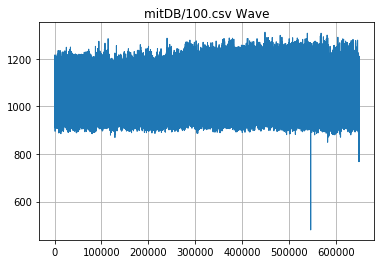

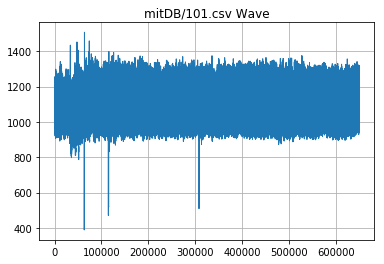

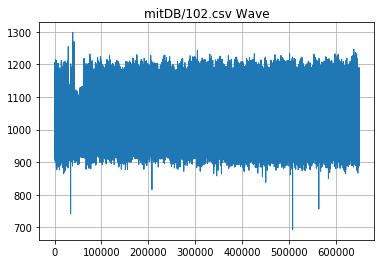

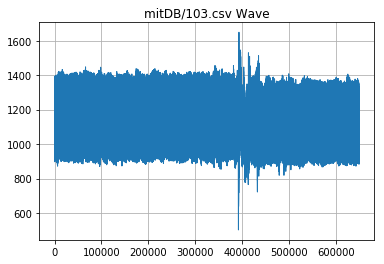

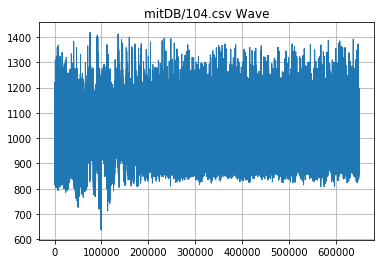

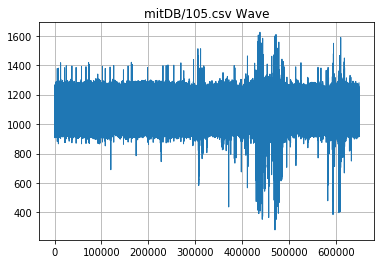

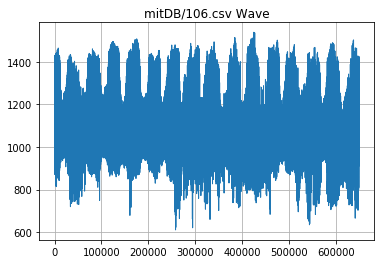

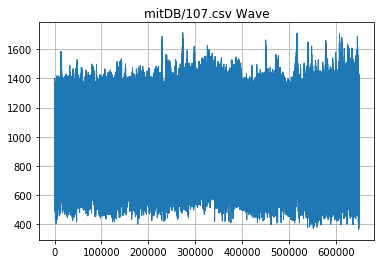

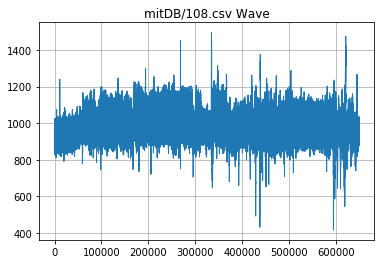

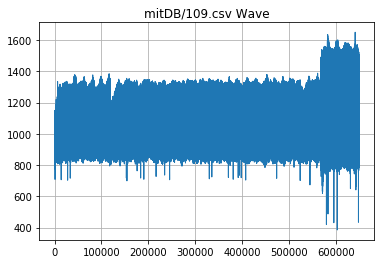

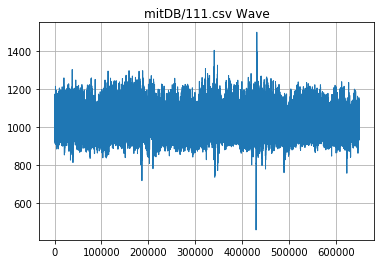

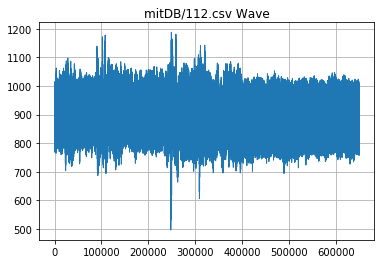

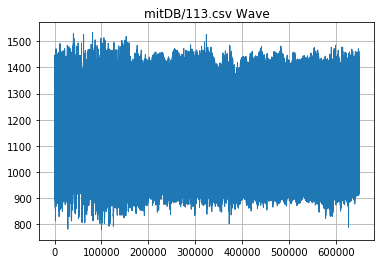

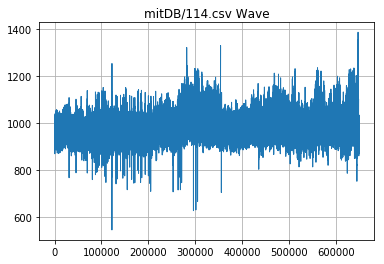

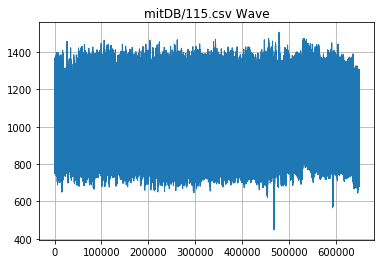

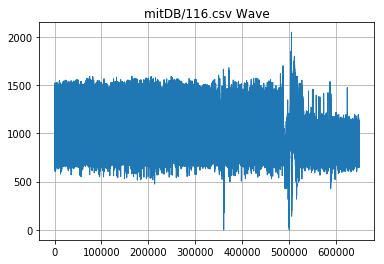

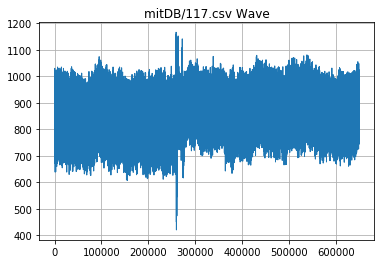

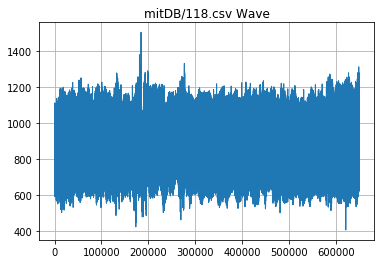

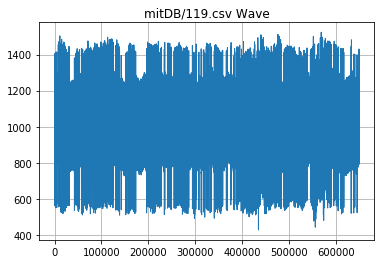

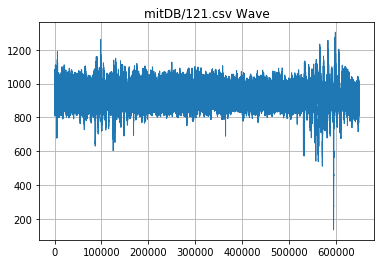

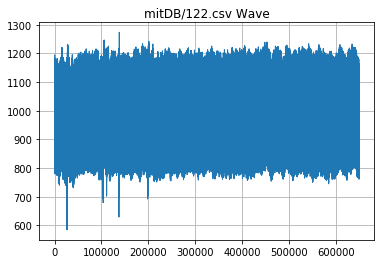

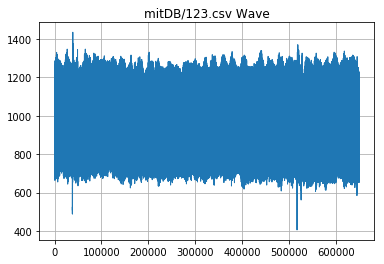

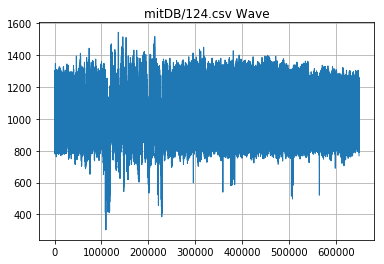

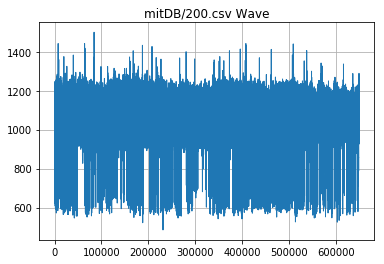

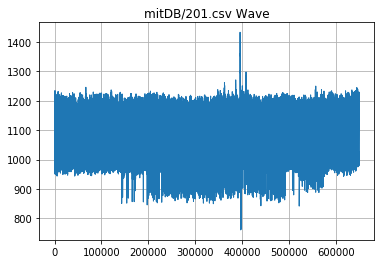

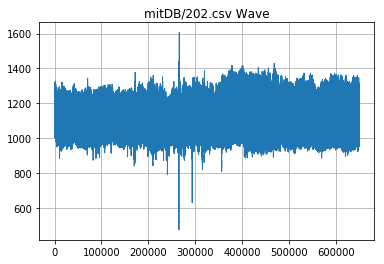

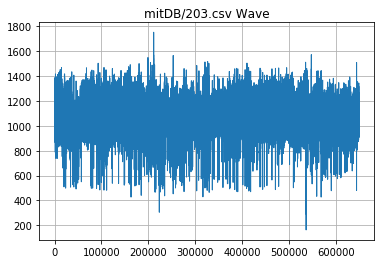

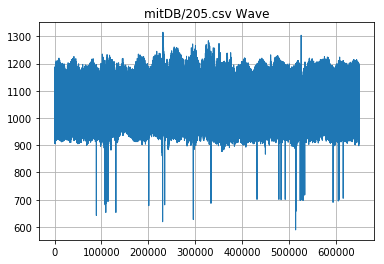

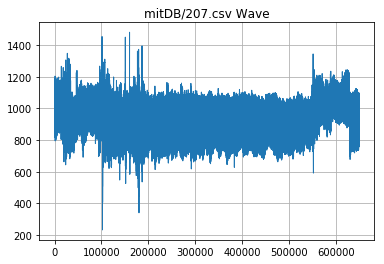

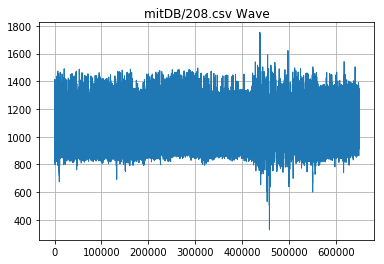

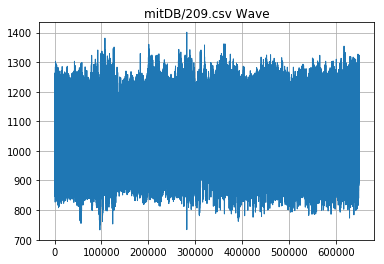

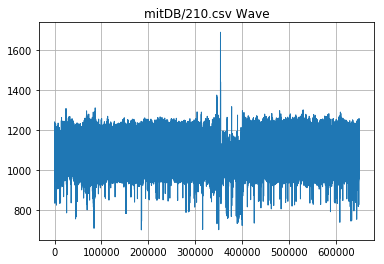

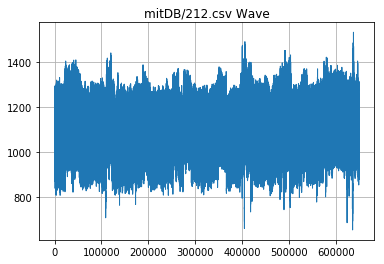

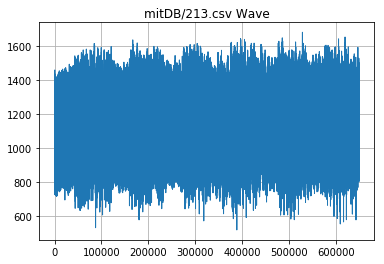

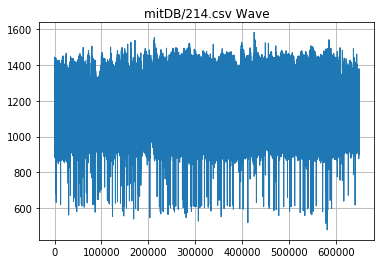

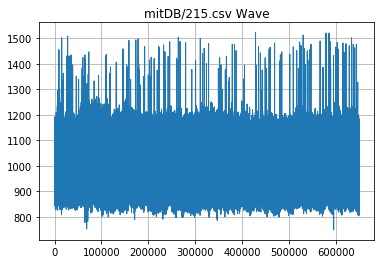

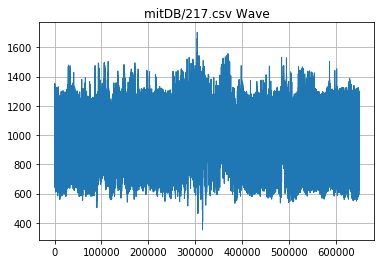

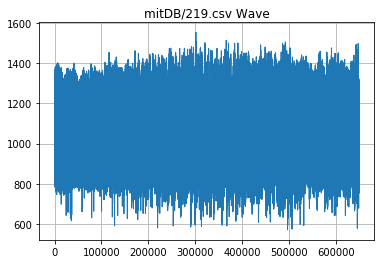

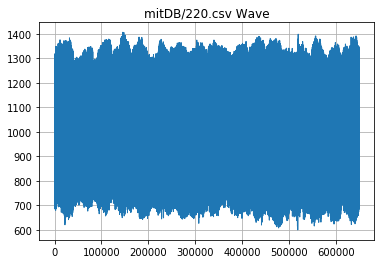

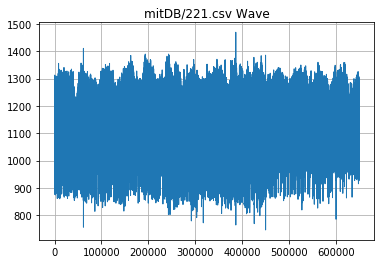

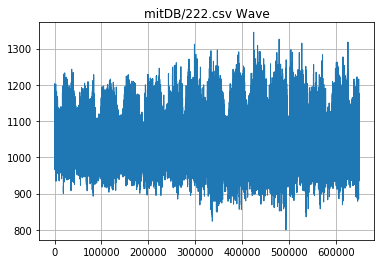

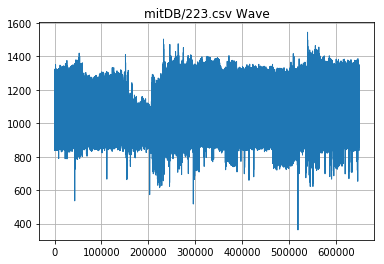

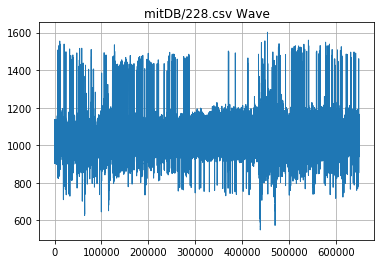

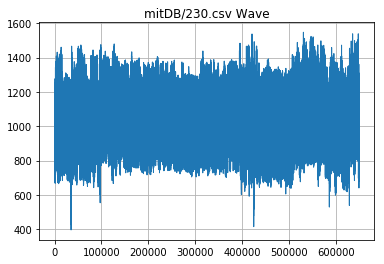

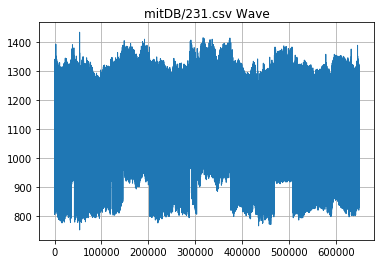

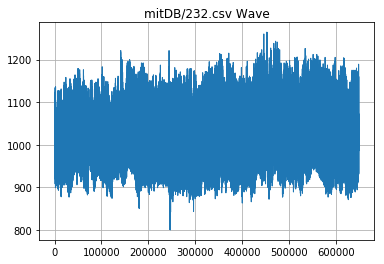

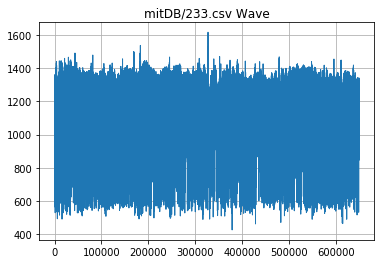

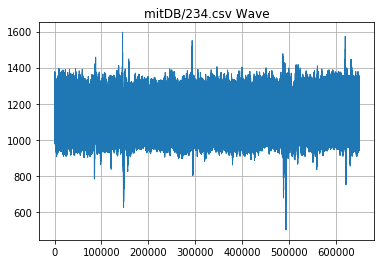

[[ 958.          960.          959.         ...  313.
    76.           76.        ]
 [ 965.          966.          967.         ...  315.
    76.           76.        ]
 [ 958.          959.          958.         ...  321.
   155.          155.        ]
 ...
 [1101.         1101.         1099.         ...   85.
   220.          257.48815166]
 [1051.         1051.         1054.         ...  255.
   210.5         257.2464455 ]
 [1055.         1058.         1060.         ...  254.
   191.2         256.76777251]]
[0 0 0 ... 0 0 0]
[[976.         974.         973.         ... 293.          59.
   59.        ]
 [958.         963.         962.         ... 292.          59.
   59.        ]
 [961.         964.         963.         ... 284.         137.
  137.        ]
 ...
 [981.         981.         979.         ... 241.         242.2
  240.28159645]
 [969.         970.         973.         ... 251.         242.4
  240.27716186]
 [973.         973.         972.         ... 240.         242.4


In [4]:
dataset = 'mitDB/'
output_path = 'trainedDataSet/'
window_size = 160
compute_RR_interval_feature = True

list_classes = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'P', '/', 'f', 'u']
"""
Arrhythmia Type List

N = 'N', 'L', 'R', 'e', 'j'
SVEB = 'A', 'a', 'J', 'S'
VEB = 'V', 'E'
F = 'F'
Q = 'P', '/', 'f', 'u'
"""

if not os.path.exists(output_path + 'mit_db_' + str(window_size) + '.p'):
    # read files
    filenames = next(os.walk(dataset))[2]

    # .csv
    num_recs = 0
    num_annotations = 0

    records = []
    annotation_files = []
    filenames.sort()

    for f in filenames:
        filename, file_extension = os.path.splitext(f)
        if(file_extension == '.csv'):  # *.csv
            records.insert(num_recs, dataset + filename + file_extension)
            num_recs += 1
        else:  # *.txt
            annotation_files.insert(num_annotations, dataset + filename + file_extension)
            num_annotations += 1

    signal = [[] for i in range(len(records))]
    classes = [[] for i in range(len(records))]
    R_poses = [[] for i in range(len(records))]
    selected_R = [np.array([]) for i in range(len(records))]
    temporal_features = [temp_features() for i in range(len(records))]
    mit_db = mit_data()

    r_index = 0
    files = []
    patients = []

    # Records
    for r in range(0,len(records)):
        signal_II = []
        
        with open(records[r], 'rt') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
            row_index = -1
            for row in spamreader:
                if(row_index >= 0):
                    signal_II.insert(row_index, int(row[1]))
                row_index += 1

        # Display each patient's signal
        plt.title(records[r] + " Wave")
        plt.plot(signal_II)
        plt.show()
        patients.append(records[r][-7:-4])

        # read anotations: R position and class
        with open(annotation_files[r], 'r') as fileID:
            data = fileID.readlines() 
            beat = 0
        
            for d in range(1, len(data)): # 0 index is Chart Head
                splitted = data[d].split(' ')
                splitted = filter(None, splitted)
                next(splitted) # Time... Clipping
                pos = int(next(splitted)) # Sample ID
                arrhythmia_type = next(splitted) # Type
                
                if(arrhythmia_type in list_classes):
                    if(pos > window_size and pos < (len(signal_II) - window_size)):
                        beat = signal_II[pos-window_size+1:pos+window_size]
                        signal[r].append(beat)
                        classes[r].append(arrhythmia_type)
                        selected_R[r] = np.append(selected_R[r], 1)
                    else:
                        selected_R[r] = np.append(selected_R[r], 0)
                R_poses[r].append(pos)

        # Compute RR Interval, feature Time
        if(compute_RR_interval_feature):

            pre_R = np.array([0])
            post_R = np.array([R_poses[r][1] - R_poses[r][0]])
            local_R = np.array([]) # Average of the ten past R intervals
            global_R = np.array([]) # Average of the last 5 minutes of the signal
            
            for i in range(1,len(R_poses[r])-1):
                pre_R = np.insert(pre_R, i, R_poses[r][i] - R_poses[r][i-1])
                post_R = np.insert(post_R, i, R_poses[r][i+1] - R_poses[r][i])
            
            pre_R[0] = pre_R[1]
            pre_R = np.append(pre_R, R_poses[r][-1] - R_poses[r][-2])
            post_R = np.append(post_R, post_R[-1])
            
            # Local R: AVG from past 10 RR intervals
            for i in range(0,len(R_poses[r])):
                avg_val = 0
                num_elems = 0
                window = range(i-10,i,1)
                
                for w in window:
                    if w >= 0:
                        avg_val = avg_val + pre_R[w]
                        num_elems += 1

                if num_elems == 0:
                    local_R = np.append(local_R, 0)   
                else:
                    avg_val = avg_val / num_elems
                    local_R = np.append(local_R, avg_val)   
            
            # Global R: AVG from past 5 minutes
            # 360 Hz  5 minutes = 108000 samples;
            for i in range(0, len(R_poses[r])):
                avg_val = 0
                back = -1
                back_length = 0
                if R_poses[r][i] < 108000:
                    window = range(0,i,1)
                else:
                    while (i + back) > 0 and back_length < 108000:
                        back_length = R_poses[r][i] - R_poses[r][i+back]
                        back = back -1
                    window = range(max(0,(back+i)), i, 1)
                    
                # Considerando distancia maxima hacia atras
                for w in window:
                    avg_val = avg_val + pre_R[w]

                if len(window) > 0:
                    avg_val = avg_val / len(window)
                else:
                    avg_val = 0
                global_R= np.append(global_R, avg_val)
            
            # Only keep those features from beats that we save list_classes
            # but for the computation of temporal features all the beats must be used
            temporal_features[r].pre_R = pre_R[np.where(selected_R[r] == 1)[0]]
            temporal_features[r].post_R = post_R[np.where(selected_R[r] == 1)[0]]
            temporal_features[r].local_R = local_R[np.where(selected_R[r] == 1)[0]]
            temporal_features[r].global_R = global_R[np.where(selected_R[r] == 1)[0]]

    # EXPORT
    mit_db.filenames = records
    mit_db.patients = patients
    mit_db.signals = signal
    mit_db.classes = classes
    mit_db.selected_R = selected_R
    mit_db.temporal_features = temporal_features
    mit_db.window_size = window_size

    # Save data
    # Protocol version 0 is the original ASCII protocol and is backwards compatible with earlier versions of Python.
    # Protocol version 1 is the old binary format which is also compatible with earlier versions of Python.
    # Protocol version 2 was introduced in Python 2.3. It provides much more efficient pickling of new-style classes.
    pickle.dump(mit_db, open(output_path + 'mit_db_' + str(window_size) + '.p', 'wb'), 2)
else:
    # Load data
    mit_db  = pickle.load(open(output_path + 'mit_db_' + str(window_size) + '.p', 'rb'))

# Select data for training
list_train_pat = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
list_test_pat = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

# Export data and label directly like Tensorflow would require     
train_data, train_labels = get_data_label_mitdb(list_train_pat, mit_db)
eval_data, eval_labels = get_data_label_mitdb(list_test_pat, mit_db)

extension = '_' + str(window_size)
if compute_RR_interval_feature:
    extension = extension + '_' + 'RR'
extension = extension + '.csv'

# Export, save
np.savetxt(output_path + 'train_data' + extension, train_data, delimiter=",")
np.savetxt(output_path + 'train_label' + extension, train_labels, delimiter=",")
np.savetxt(output_path + 'eval_data' + extension, eval_data, delimiter=",")
np.savetxt(output_path + 'eval_label' + extension, eval_labels, delimiter=",")
